# Cropbox Lab Exercises for Modeling Leaf Gas-Exchange Processes

In this notebook, we will use Cropbox to examine leaf gas-exchange behavior. We will recreate the leaf-gas exchange responses we looked at using PGES. Keep PGES open in one window to compare with Cropbox results.

<div class="alert alert-warning">
If figures/tables are not rendered correctly, make sure your notebook is `trusted` by choosing `Trust Notebook` command found in `View` - `Activate Command Palette` menu. Typing in the first letters (i.e. "tr") should give you the command.
</div>

In [1]:
using Cropbox

We will use interactive plotting feature in this notebook. For this, we have to initialize [WebIO.jl](https://github.com/JuliaGizmos/WebIO.jl) manually when using [prebuilt system images](https://github.com/JuliaLang/PackageCompiler.jl) as we do with our JupyterHub environment.

In [2]:
Cropbox.Interact.WebIO.setup(:ijulia)

WebIO._IJuliaInit()

## Coupled Leaf Gas-Exchange Model

The coupled leaf gas-exchange model was derived from [Kim and Lieth (2003)](https://doi.org/10.1093/aob/mcg080). Its implemetation in Cropbox focusing on C4 leaves is available from [Yun, Timlin, and Kim (2020)](https://doi.org/10.3390/plants9101358). A standalone package for couple leaf gas-exchange model is available as [LeafGasExchange.jl](https://github.com/cropbox/LeafGasExchange.jl). We will use this standalong package to study leaf gas-exchange behavior without going into the details about the inner-workings of the model . 

In [3]:
using LeafGasExchange

#### C3 Photosynthesis model and its parameters

$$
A_n = \min \{ A_c, A_j, A_p \}
$$

$$
A_c = V_{c\!\max} \frac{C_i - \Gamma}{C_i + K_c \cdot (1 + \frac{O_m}{K_o})} - R_d
$$

$$
A_j = \frac{J \cdot (C_i - \Gamma)}{4 (C_i + 2 \Gamma)} - R_d
$$

$$
A_p = 3T_p - R_d
$$

| Symbol | Units | Description |
|:-------|:------|:------------|
| $A_c$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Rubisco-limited $\mathrm{CO_2}$ assimilation rate |
| $A_j$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Electron transport-limited $\mathrm{CO_2}$ assimilation rate |
| $A_n$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Net photosynthesis rate |
| $A_p$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Triose phosphate utilization-limited $\mathrm{CO_2}$ assimilation rate |
| $C_a$ | $\mathrm{\mu bar}$ | Atmospheric $\mathrm{CO_2}$ partial pressure |
| $C_i$ | $\mathrm{\mu bar}$ | Intercellular $\mathrm{CO_2}$ partial pressure |
| $C_m$ | $\mathrm{\mu bar}$ | Mesophyll $\mathrm{CO_2}$ partial pressure |
| $\Gamma$ | $\mathrm{\mu bar}$ | $\mathrm{CO_2}$ compensation point |
| $J$ | $$\mathrm{\mu mol_{electron}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$$ | Electron transport rate |
| $J_{\max}$ | $\mathrm{\mu mol_{electron}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Maximum rate of electron transport |
| $K_c$ | $\mathrm{\mu bar}$ | Michaelis-Menton constant of Rubisco for $\mathrm{CO_2}$ |
| $K_m$ | $\mathrm{\mu bar}$ | Michaelis-Menton constant of Rubisco for $\mathrm{CO_2}$ in presence of $\mathrm{O_2}$ |
| $K_o$ | $\mathrm{mbar}$ | Michaelis-Menton constant of Rubisco for $\mathrm{O_2}$ |
| $P_a$ | $\mathrm{kPa}$ | Atmospheric pressure |
| $R_d$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Mitochondrial respiration rate |
| $r_{v_c}$ | $\mathrm{m^2}\ \mathrm{s}\ \mathrm{mol^{-1}_{CO_2}}\ \mathrm{bar}$ | Total leaf resistance to $\mathrm{CO_2}$ |
| $T_p$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Maximum rate of triose phosphate utilization |
| $V_{c\!\max}$ | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Maximum rate of Rubisco carboxylation |

| Symbol | Value | Units | Description |
|:-------|:------|:------|:------------|
$E_{ac}$ | 79.43 | $\mathrm{kJ}\ \mathrm{mol^{-1}}$ | Activation energy for $K_c$ |
$E_{ag}$ | 37.83 | $\mathrm{kJ}\ \mathrm{mol^{-1}}$ | Activation energy for $\Gamma$ |
$E_{aj}$ | 23.9976 | $\mathrm{kJ}\ \mathrm{mol^{-1}}$ | Activation energy for $J_{\max}$ |
$E_{ao}$ | 36.38 | $\mathrm{kJ}\ \mathrm{mol^{-1}}$ | Activation energy for $K_o$ |
$E_{ar}$ | 49.39 | $\mathrm{kJ}\ \mathrm{mol^{-1}}$ | Activation energy for $R_d$ |
$E_{aVc}$ | 52.1573 | $\mathrm{kJ}\ \mathrm{mol^{-1}}$ | Activation energy for $V_{c\!\max}$ |
$E_{aTp}$ | 47.10 | $\mathrm{kJ}\ \mathrm{mol^{-1}}$ | Activation energy for $T_p$ |
$\Gamma_{25}$ | 42.75 | $\mathrm{\mu bar}$ | $\mathrm{CO_2}$ compensation point at 25 $\mathrm{^{\circ}C}$ |
$H_j$ | 200 | $\mathrm{kJ}\ \mathrm{mol^{-1}}$ | Curvature parameter for $J_{\max}$ |
$J_{\max_{25}}$ | 169 | $$\mathrm{mol_{electron}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}\ \mathrm{bar^{-1}}$$ | Maximum rate of electron transport at 25 $\mathrm{^{\circ}C}$ |
$K_{c_{25}}$ | 404.9 | $\mathrm{\mu bar}$ | Michaelis-Menton constant of Rubisco for $\mathrm{CO_2}$ at 25 $\mathrm{^{\circ}C}$ |
$K_{o_{25}}$ | 278.4 | $\mathrm{mbar}$ | Michaelis-Menton constant of Rubisco for $\mathrm{O_2}$ at 25 $\mathrm{^{\circ}C}$ |
$O_m$ | 210 | $\mathrm{mbar}$ | Mesophyll $\mathrm{O_2}$ partial pressure |
$R_{d_{25}}$ | 1.08 | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Mitochondrial respiration rate at 25 $\mathrm{^{\circ}C}$ |
$S_j$ | 616.4 | $\mathrm{J}\ \mathrm{mol^{-1}}\ \mathrm{K}$ | Entropy factor for $J_{\max}$ |
$\theta$ | 0.7 | - | Sharpness of transition between light limitation and saturation |
$T_b$ | 25 | $\mathrm{^{\circ}C}$ | Base temperature in Celsius |
$T_{b_k}$ | 298.15 | $\mathrm{K}$ | Base temperature in Kelvin |
$T_{p_{25}}$ | 16.03 | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Triose phosphate utilization rate at 25 $\mathrm{^{\circ}C}$ |
$V_{c\!\max_{25}}$ | 108.4 | $\mathrm{\mu mol_{CO_2}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$ | Maximum rate of Rubisco carboxylation at 25 $\mathrm{^{\circ}C}$ |

Let's examine the relational diagrams for 1) the structure of C3 leaf gas-exchange model implementing the FvCB and Ball-Berry models and 2) the interdependency of its variables.

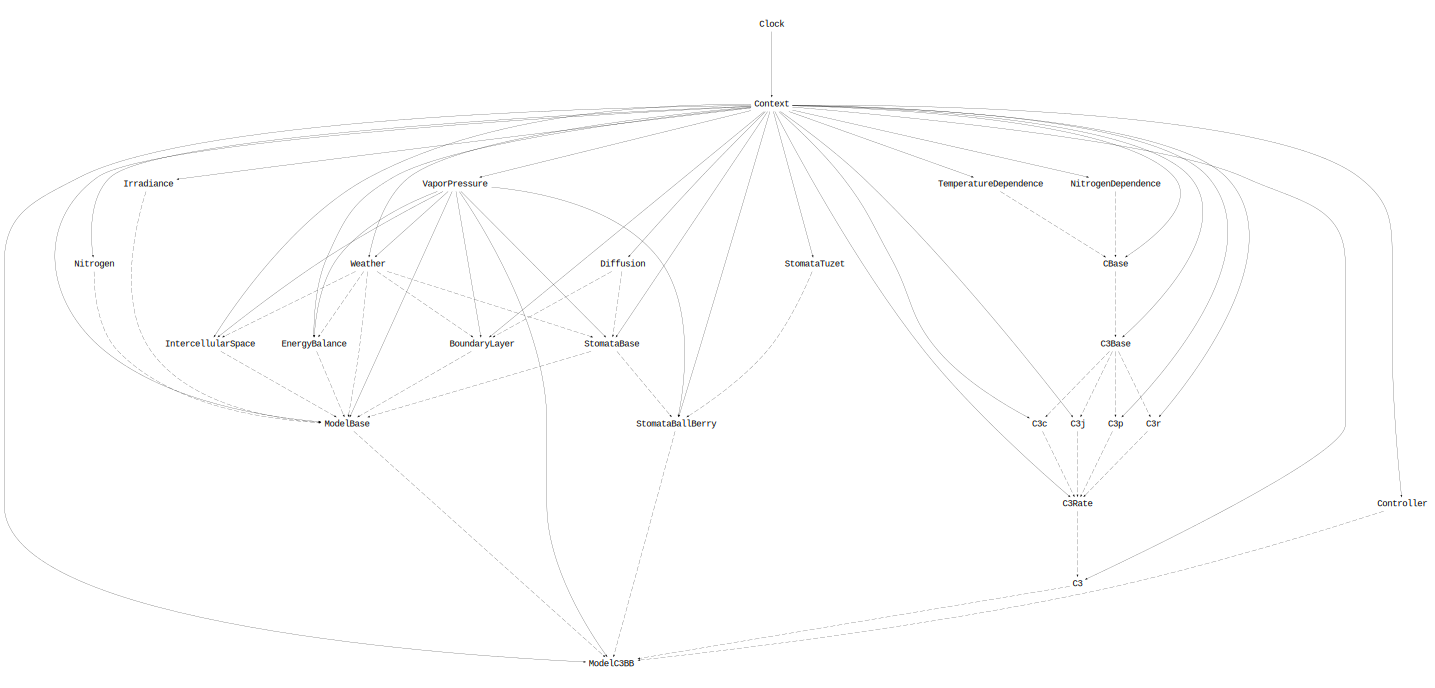

In [4]:
Cropbox.hierarchy(LeafGasExchange.ModelC3BB)

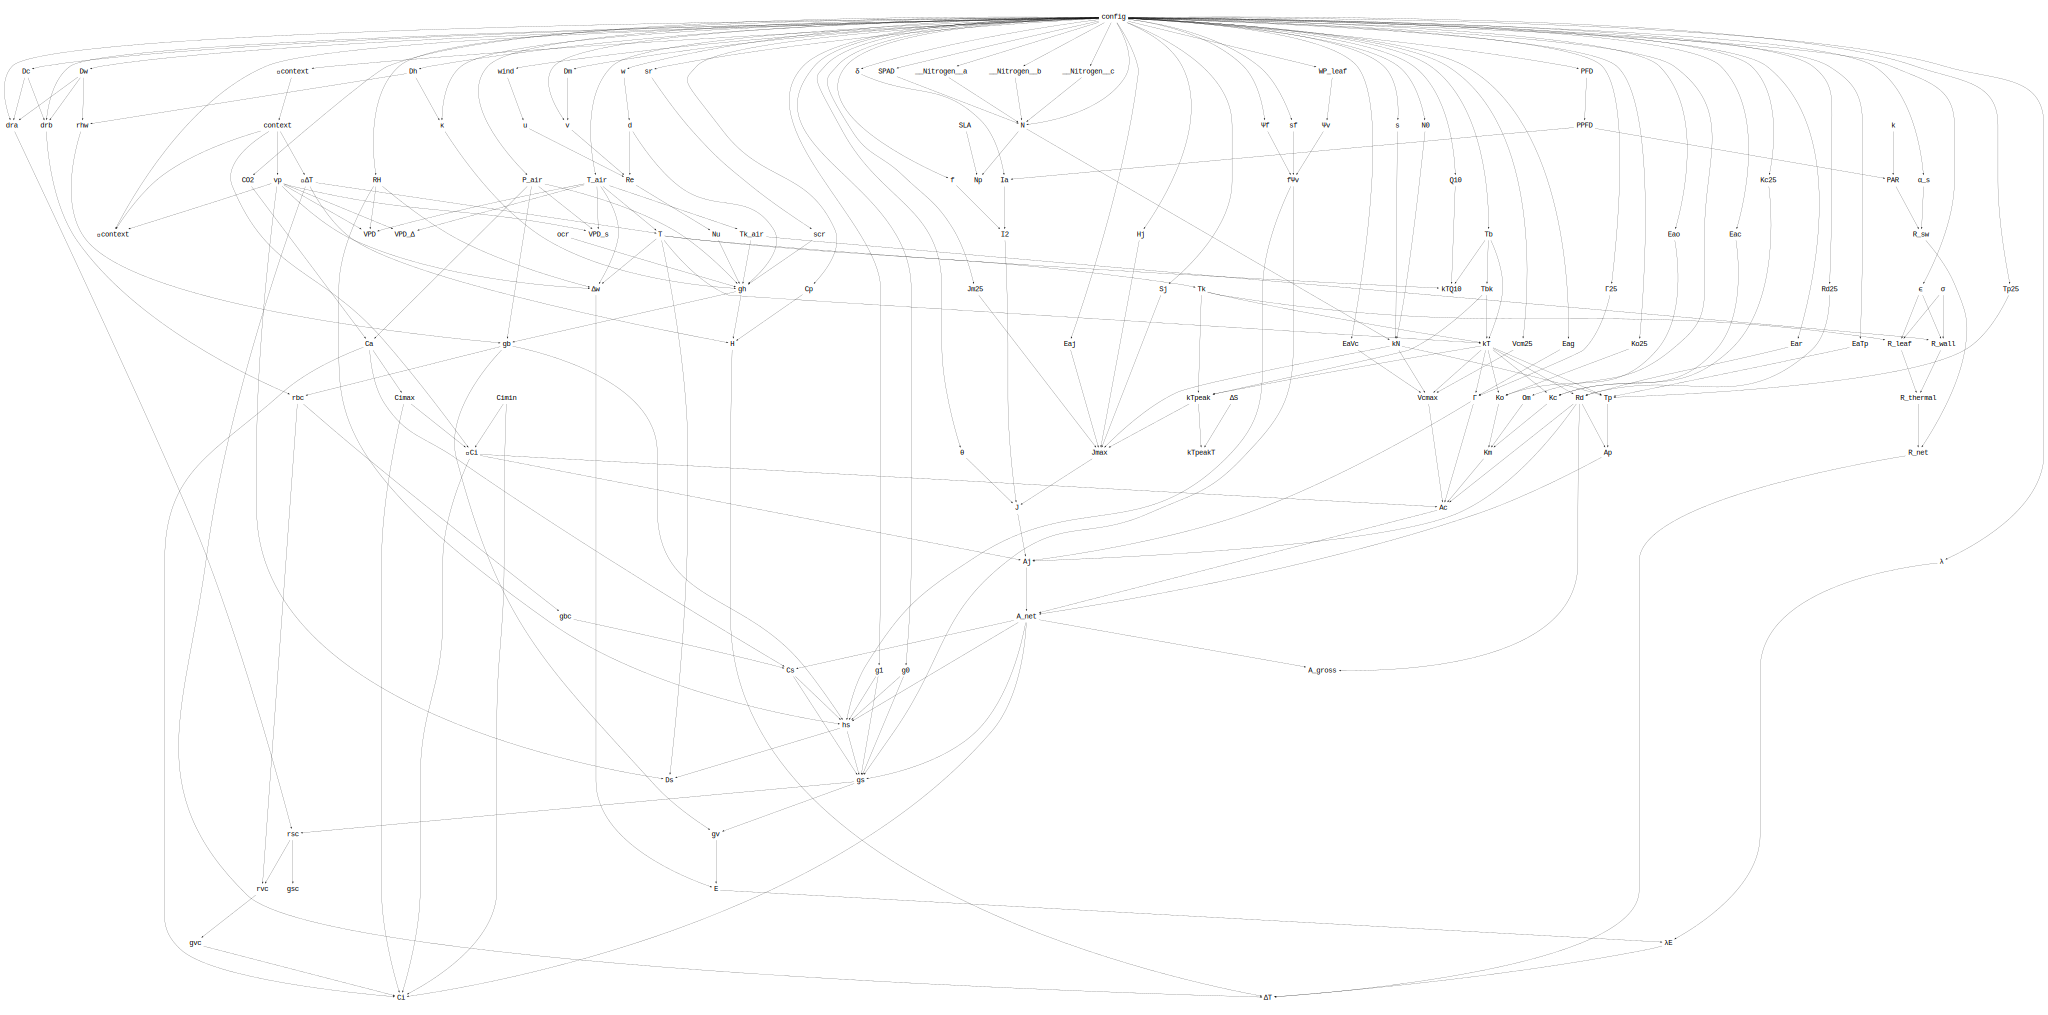

In [5]:
Cropbox.dependency(LeafGasExchange.ModelC3BB)

### Lab Ex 1.2 and Ex 1.3 will be addressed together.

##### Ex 1.2) Use PGES or Cropbox to examine how photosynthesis, stomatal conductance, and transpiration at the leaf level will respond to light (PFD; photosynthetic photon flux density), $\mathrm{CO_2}$ in the air, air temperature (Air T), relative humidity (RH), and soil or leaf water potential (SWP or WP_leaf) with default leaf traits for rose and maize. Evaluate and discuss the results. How are they similar or different? Do model predictions make sense to you? Discuss why or why not.

##### Ex 1.3) Based on the coupled models of C3 and C4 leaves, generate $A/C_i$ and light response ($A/Q$) curves for C3 (rose) and C4 (maize) leaves, and identify the regions limited by each of the three steps (i.e., $A_c$, $A_j$, or $A_p$). Assume that all other conditions are optimal for photosynthesis except the variable of interest (i.e., $\mathrm{CO_2}$ and PFD).

To answer these questions, we first need to check the deafult parameter values for C3 photosynthesis and Ball-Berry stomatal conductatance models implemented in LeafGasExchange package, and make a new instance for species of interest. We will focus on rose, a C3 plant. The same approach method can apply for maize which is a C4 plant.

In [6]:
c1 = parameters(LeafGasExchange.ModelC3BB)

Config for 1 system:
  ModelC3BB
    PFD           = nothing
    CO2           = nothing
    RH            = nothing
    T_air         = nothing
    wind          = nothing
    P_air         = 100 kPa
    SPAD          = 60
    (Nitrogen) _a = 0.0004 g m^-2
    (Nitrogen) _b = 0.012 g m^-2
    (Nitrogen) _c = 0 g m^-2
    N             = missing
    Dw            = 24.2 mm^2 s^-1
    Dc            = 14.7 mm^2 s^-1
    Dh            = 21.5 mm^2 s^-1
    Dm            = 15.1 mm^2 s^-1
    w             = 10 cm
    sr            = 1.0
    v             = missing
    κ             = missing
    g0            = 0.017 mol bar^-1 m^-2 s^-1
    g1            = 4.53
    drb           = missing
    dra           = missing
    δ             = 0.15
    f             = 0.15
    ϵ             = 0.97
    λ             = 44 kJ mol^-1
    Cp            = 29.3 J K^-1 mol^-1
    α_s           = 0.5
    WP_leaf       = 0 MPa
    Ψf            = -2.0 MPa
    sf            = 2.3 MPa^-1
    Tb            = 2

From [Kim and Lieth (2003)](https://doi.org/10.1093/aob/mcg080), we see that some of the FcVB and Ball-Berry model parameter values for rose leaves are different than the default values. We will create a new parameter configuration for a rose leaf and update their parameter values as described in [Kim and Lieth (2003)](https://doi.org/10.1093/aob/mcg080). The current version of LeafGasExchange package rquires optimal temperature for J (Toj). Toj can be obtained from the function below based on Sj, Eaj (or Haj), and Hj (or Hdj).

In [7]:
# Create a gas-exchange configuration for rose leaf
ge_rose = @config (
    :C3 => (
        Vcm25 = 102.4, Jm25 = 162.0, Tp25 = 11.55, Rd25 = 1.260,
        Kc25 = 404, Ko25 = 248, Eac = 59.4, Eao = 36.0, Ear = 66.4, EaVc = 45.5,
        Eaj = 43.3, Hj = 219.4, Sj = 704.2, Γ25 = 36.9,
    ),
    :StomataBallBerry => (g0 = 0.096, g1 = 10.055),
    :Weather => (
        PFD = 1500,
        CO2 = 400,
        RH = 60,
        T_air = 25,
        wind = 2.0,
    )
)

Config for 3 systems:
  C3
    Vcm25 = 102.4
    Jm25  = 162.0
    Tp25  = 11.55
    Rd25  = 1.26
    Kc25  = 404
    Ko25  = 248
    Eac   = 59.4
    Eao   = 36.0
    Ear   = 66.4
    EaVc  = 45.5
    Eaj   = 43.3
    Hj    = 219.4
    Sj    = 704.2
    Γ25   = 36.9
  StomataBallBerry
    g0 = 0.096
    g1 = 10.055
  Weather
    PFD   = 1500
    CO2   = 400
    RH    = 60
    T_air = 25
    wind  = 2.0

In [8]:
@config c1 + ge_rose 

Config for 4 systems:
  ModelC3BB
    PFD           = nothing
    CO2           = nothing
    RH            = nothing
    T_air         = nothing
    wind          = nothing
    P_air         = 100 kPa
    SPAD          = 60
    (Nitrogen) _a = 0.0004 g m^-2
    (Nitrogen) _b = 0.012 g m^-2
    (Nitrogen) _c = 0 g m^-2
    N             = missing
    Dw            = 24.2 mm^2 s^-1
    Dc            = 14.7 mm^2 s^-1
    Dh            = 21.5 mm^2 s^-1
    Dm            = 15.1 mm^2 s^-1
    w             = 10 cm
    sr            = 1.0
    v             = missing
    κ             = missing
    g0            = 0.017 mol bar^-1 m^-2 s^-1
    g1            = 4.53
    drb           = missing
    dra           = missing
    δ             = 0.15
    f             = 0.15
    ϵ             = 0.97
    λ             = 44 kJ mol^-1
    Cp            = 29.3 J K^-1 mol^-1
    α_s           = 0.5
    WP_leaf       = 0 MPa
    Ψf            = -2.0 MPa
    sf            = 2.3 MPa^-1
    Tb            = 

Try running the next cell and see what happens. Think about why that happens. Try uncommenting the Weather configuration lines in the cell above (use Ctrl +/), and rerun the next cell.

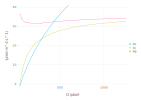

In [9]:
visualize(LeafGasExchange.ModelC3BB, :Ci, [:Ac, :Aj, :Ap];
    config = ge_rose,
    xstep = :Weather => :CO2 => 10:10:1500,
    ylim = (0,40),
    kind = :line,
)

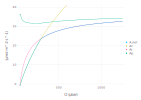

In [10]:
# Generate CO2 response curves (aka A-Ci curve) for all three limiting steps 
visualize(LeafGasExchange.ModelC3BB, :Ci, [:A_net, :Ac, :Aj, :Ap];
    config = ge_rose,
    xstep = :Weather => :CO2 => 10:10:1500,
    ylim = (0,40),
    kind = :line,
)

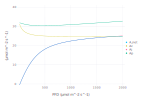

In [11]:
# Generate light response curves (aka A-Q curve) for all three limiting steps 
visualize(LeafGasExchange.ModelC3BB, :PFD, [:A_net, :Ac, :Aj, :Ap];
    config = ge_rose,
    xstep = :Weather => :PFD => 10:10:2000,
    ylim = (0,40),
    kind = :line,
)

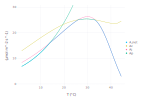

In [12]:
# Generate temperature response curves of A and its three limiting steps 
visualize(LeafGasExchange.ModelC3BB, :T, [:A_net, :Ac, :Aj, :Ap];
    config = ge_rose,
    xstep = :Weather => :T_air => 0:1:45,
    ylim = (0,30),
    kind = :line,
)

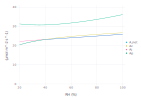

In [13]:
# Generate relative humidity response curves of A and its three limiting steps 
visualize(LeafGasExchange.ModelC3BB, :RH, [:A_net, :Ac, :Aj, :Ap];
    config = ge_rose,
    xstep = :Weather => :RH => 20:5:100,
    ylim = (0,40),
    kind = :line,
)

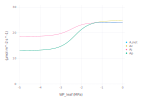

In [14]:
# Generate leaf water potential response curves of A and its three limiting steps
visualize(LeafGasExchange.ModelC3BB, :WP_leaf, [:A_net, :Ac, :Aj, :Ap];
    config = ge_rose,
    xstep = :StomataTuzet => :WP_leaf => -5:0.02:0,
    ylim = (0,30),
    kind = :line,
)

### Lab Ex 1.4

##### Ex 1.4) Explore how a rose (C3) and maize (C4) leaf would respond to a range of temperatures under the atmospheric $\mathrm{CO_2}$ concentrations of **250 ppm (sub-ambient), 400 ppm (ambient), and 1000 ppm (elevated)**. Assume other environmental conditions are constant and favorable under saturating light level (PFD = 2,000 $\mathrm{\mu mol_{photons}}\ \mathrm{m^{-2}}\ \mathrm{s^{-1}}$).

* Generate figures to compare C3 and C4 temperature response curves at the three $\mathrm{CO_2}$ concentrations.
* Identify the **air temperature and $\mathrm{CO_2}$** conditions where photorespiration becomes substantial, and discuss how you identified those conditions.
* Do the same comparisons with a water-stressed C3 rose leaf at -1.5 MPa of soil water potential or -3.0 MPa of leaf water potential, and compare their responses to fully turgid leaf with water potential close to 0 MPa. 

In [15]:
# Predefine steps to run
co2_xstep = :Weather => :CO2   => 10:10:1500;
ta_xstep  = :Weather => :T_air => 0:1:45;
WP_xstep = :StomataTuzet => :WP_leaf => -5:0.02:0;

In [16]:
# Predefine grouping variables and their values
co2_group = :Weather => :CO2   => [1000, 400, 250];
WP_group = :StomataTuzet => :WP_leaf => [0, -3.0];

In [17]:
@config co2_group

Config for 1 system:
  Weather
    CO2 = [1000, 400, 250]

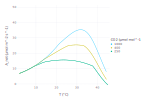

In [18]:
visualize(LeafGasExchange.ModelC3BB, :T, :A_net;
    config = ge_rose,
    xstep = ta_xstep,
    group = co2_group,
    ylim = (0,50),
    kind = :line,
)

In [19]:
# Provide basic weather input to run C4 model 
ge_config = @config :Weather => (
    PFD = 1500,
    CO2 = 400,
    RH = 60,
    T_air = 30,
    wind = 2.0,
)

Config for 1 system:
  Weather
    PFD   = 1500
    CO2   = 400
    RH    = 60
    T_air = 30
    wind  = 2.0

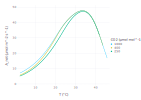

In [20]:
visualize(LeafGasExchange.ModelC4BB, :T, :A_net;
    config = ge_config,
    xstep = ta_xstep,
    group = co2_group,
    ylim = (0,50),
    kind = :line,
)

In [21]:
@config ge_rose

Config for 3 systems:
  C3
    Vcm25 = 102.4
    Jm25  = 162.0
    Tp25  = 11.55
    Rd25  = 1.26
    Kc25  = 404
    Ko25  = 248
    Eac   = 59.4
    Eao   = 36.0
    Ear   = 66.4
    EaVc  = 45.5
    Eaj   = 43.3
    Hj    = 219.4
    Sj    = 704.2
    Γ25   = 36.9
  StomataBallBerry
    g0 = 0.096
    g1 = 10.055
  Weather
    PFD   = 1500
    CO2   = 400
    RH    = 60
    T_air = 25
    wind  = 2.0

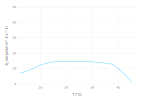

In [22]:
visualize(LeafGasExchange.ModelC3BB, :T, :A_net;
    config = (ge_rose, (:StomataTuzet => :WP_leaf => -3.0)),
    xstep = ta_xstep,
#    group = WP_group,
    ylim = (0,50),
    kind = :line,
)

Cropbox supports `manipulate()` function to build an interactive plot. It looks like `visualize()` but also accepts a range of parameter values in `parameters` argument as similar to `calibrate()` function. Then these parameter ranges will be automatically transformed into a set of interactive widgets like sliders. This feature is implemented based on [Interact.jl](https://github.com/JuliaGizmos/Interact.jl) and [WebIO.jl](https://github.com/JuliaGizmos/WebIO.jl).

In [23]:
manipulate(LeafGasExchange.ModelC3BB, :WP_leaf, :A_net;
    config = ge_rose,
    parameters = :StomataBallBerry => (;
        g0 = 0:0.01:1,
        g1 = 0:0.1:15,
    ),
    xstep = WP_xstep,
    ylim = (0,30),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["StomataBallBerry"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["g0"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 101, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
11, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f43499112c0, Task (runnable) @0x00007f43499112c0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n       

In [24]:
manipulate(LeafGasExchange.ModelC3BB, :T, [:A_net, :Ac, :Aj, :Ap],
    config = ge_rose,
    parameters = :Weather => (;
        CO2   = 10:10:1500,
        PFD   = 0:20:2000,
    ),
    xstep = :Weather => :T_air => -10:1:50,
    xlim = (-10, 50),
    ylim = (0, 50),
    kind = :line,
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["Weather"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["CO2"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 150, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
40, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f4349934d00, Task (runnable) @0x00007f4349934d00), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\

In [25]:
# Examine the relationship between supply and demand functions of photosynthesis
import Cropbox.Gadfly as G
visualize_ACi(S, targets = [:A_net], Ca = nothing;
    config = (),
    xstep = :Weather => :CO2 => 50:50:1500,
    kw...
) = begin
    c = @config(config)
    R = simulate(S; target = [:Ci, :Ca, :CO2, :gs, targets...], configs = @config(c + !xstep))
    p = plot(R, :Ci, targets; kind = :line, kw...)
    for r in eachrow(deunitfy(R))
        x1, y1 = r.Ci, r.A_net
        x2, y2 = r.Ca, 0
        m = (y2 - y1) / (x2 - x1)
        f = x -> m * (x - x1) + y1
        if isequal(r.CO2, Cropbox.option(c, :Plot, :CO2))
            theme = G.Theme(default_color = "gray", line_style = [:solid])
            info = "An = $(round(r.A_net, digits=1)) μmol/m^2/s\ngs = $(round(r.gs, digits=3)) mol/m^2/s/bar"
            guide = G.Guide.annotation(
                G.compose(
                    G.context(),
                    G.Compose.text((x1+x2)/2 + 20, (y1+y2)/2, info),
                    G.fontsize(theme.minor_label_font_size),
                )
            )
            G.push!(p[], guide)
        else
            theme = G.Theme(default_color = "lightgray", line_style = [:dot])
        end
        l = G.layer(f, x1, x2, theme)
        G.push!(p[], l)
    end
    p
end

visualize_ACi (generic function with 3 methods)

In [26]:
manipulate(config = ge_rose, parameters = (
    :StomataTuzet => :WP_leaf => -3:0.1:0,
    :Weather      => :PFD     => 0:100:2000,
    :Weather      => :T_air   => 0:1:50,
    :Plot         => :CO2     => 50:50:1500,
)) do c
    visualize_ACi(LeafGasExchange.ModelC3BB, [:A_net, :Ac, :Aj, :Ap];
        config = c,
        xstep = :Weather => :CO2 => 50:50:1500,
        xlim = (0, 1500),
        ylim = (0, 40),
    )
end

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any["StomataTuzet"], Dict{Symbol, Any}(:style => Dict{String, Any}("color" => :darkorchid, "font-family" => "monospace"))), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["WP_leaf"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px", "white-space" => :nowrap, "color" => :royalblue)))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 31, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget", :style => Dict("font-family" => "monospace", "width" => "80%"))), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 2 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
16, nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/opt/julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/all.js"), WebIO.Asset("css", nothing, "/opt/julia/packages/InteractBase/h8Fwe/src/../assets/style.css"), WebIO.Asset("css", nothing, "/opt/julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f43499352c0, Task (runnable) @0x00007f43499352c0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n       